In [18]:
from google.colab import drive
drive.mount('/content/drive/')

dataset_path = "/content/drive/MyDrive/datasets/ODIR-5K"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Imports

In [19]:
import os
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from tqdm import tqdm
import numpy as np
import cv2
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


# Prepare Data Script

To handle the varying aspect ratios of the input images, we first detected the bounding box of the fundus region in each image. We then resized this cropped region to a fixed input size appropriate for each model.

In [ ]:
def get_fundus_bounding_box(image):
  gray_image = image.convert("L")
  np_image = np.array(gray_image)

  non_black_pixels = np_image > 0
  rows = np.any(non_black_pixels, axis=1)
  cols = np.any(non_black_pixels, axis=0)

  y_min, y_max = np.where(rows)[0][[0, -1]]
  x_min, x_max = np.where(cols)[0][[0, -1]]
  return (x_min, y_min, x_max, y_max)

def resize_fundus(image, target_size=(224, 224)):

  bounding_box = get_fundus_bounding_box(image)

  cropped_image = image.crop(bounding_box)

  resized_image = cropped_image.resize(target_size, Image.Resampling.LANCZOS)

  return resized_image

def apply_clahe(pil_img):
  img = np.array(pil_img.convert("RGB"))
  lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
  l, a, b = cv2.split(lab)
  clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
  l_eq = clahe.apply(l)
  lab_eq = cv2.merge((l_eq, a, b))
  img_eq = cv2.cvtColor(lab_eq, cv2.COLOR_LAB2RGB)
  return Image.fromarray(img_eq)

def data_preprocess(image, use_clahe = True):

    image = resize_fundus(image, target_size=(224, 224))
    if(use_clahe):
      image = apply_clahe(image)

    return image


def preprocess_and_cache(raw_dir, preprocessed_dir, target_size=(224, 224), use_clahe = True):
    os.makedirs(preprocessed_dir, exist_ok=True)

    for fname in tqdm(os.listdir(raw_dir)):
        if not fname.lower().endswith((".jpg")):
            continue

        raw_path = os.path.join(raw_dir, fname)
        preprocessed_path = os.path.join(preprocessed_dir, fname)

        if os.path.exists(preprocessed_path):
            continue  # already processed

        try:
            img = Image.open(raw_path).convert("RGB")
            enhanced = data_preprocess(img)
            enhanced.save(preprocessed_path, format="PNG")
        except Exception as e:
            print(f"Error processing {fname}: {e}")

raw_dir = os.path.join(dataset_path, "images/images")
preprocessed_dir = os.path.join(dataset_path, "images/preprocessed")
preprocess_and_cache(raw_dir, preprocessed_dir)

100%|██████████| 7000/7000 [00:21<00:00, 322.54it/s] 


# Dataset for Paired-Eye Multi-Label Classification

This `Dataset` class is designed for multi-label classification using paired fundus images from both eyes of a patient. Each sample includes:

1.  The left eye fundus image
2.  The right eye fundus image
3.  A multi-label vector indicating the presence of absence of the conditions.

In [ ]:
class ODIRDataset(Dataset):
  def __init__(self, df, root_dir, transform=None):
    self.df = df
    self.root_dir = root_dir
    self.transform = transform

    self.classes = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
    self.left = self.df["Left-Fundus"].apply(lambda x: os.path.join(self.root_dir, x)).tolist()
    self.right = self.df["Right-Fundus"].apply(lambda x: os.path.join(self.root_dir, x)).tolist()



  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    try:
      image1 = Image.open(self.left[idx]).convert("RGB")
      image2 = Image.open(self.right[idx]).convert("RGB")
    except Exception as e:
        print(f"Error loading image at index {idx}:")
        print(f"  Left: {self.left[idx]}")
        print(f"  Right: {self.right[idx]}")
        raise e

    if self.transform:
      image1 = self.transform(image = np.array(image1))['image']
      image2 = self.transform(image = np.array(image2))['image']


    label = torch.tensor(self.df.iloc[idx][self.classes].values.astype('float32'))

    return image1, image2, label

# New Dataloader Version

In [ ]:
#New Dataloader
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

raw_dir = os.path.join(dataset_path, "images/images")
preprocessed_dir = os.path.join(dataset_path, "images/preprocessed")
df = pd.read_excel(os.path.join(dataset_path, "annotations.xlsx"))

train_df, temp_df = train_test_split(df, test_size=0.4, random_state=0)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=0)

# # Albumentations transform (only for training)
albumentations_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

# For val/test: no augmentation, only resize/normalize
eval_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

train_dataset = ODIRDataset(train_df, preprocessed_dir, transform=albumentations_transform)
val_dataset = ODIRDataset(val_df, preprocessed_dir, transform=eval_transform)
test_dataset = ODIRDataset(test_df, preprocessed_dir, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
df_raw = ODIRDataset(df, raw_dir, transform=None)
df_preprocessed = ODIRDataset(df, preprocessed_dir, transform=albumentations_transform)






## Plot Class Distribution
Plots the frequency of each disease label.

In [ ]:
# Check how imbalanced the dataset is
import matplotlib.pyplot as plt

class_counts = df[dataset.classes].sum().sort_values(ascending=False)
class_counts.plot(kind='bar', title='Class Distribution')
plt.ylabel('Image Count')
plt.show()


NameError: name 'dataset' is not defined

# Training Loop

#Loss Functions Used:
  - CB-FL
  - FL

In [ ]:
import torch
import torch.nn.functional as F

def CB_focal_loss_multilabel(labels, logits, samples_per_cls, beta=0.9999, gamma=1.5, reduction='mean'):
    """
    Class-Balanced Focal Loss for multi-label classification.

    Args:
        labels (Tensor): Ground truth binary labels, shape [B, C]
        logits (Tensor): Raw model outputs (before sigmoid), shape [B, C]
        samples_per_cls (List[int] or Tensor): Number of samples per class (length C)
        beta (float): Hyperparameter for effective number smoothing (close to 1, e.g., 0.9999)
        gamma (float): Focal loss focusing parameter
        reduction (str): 'mean', 'sum', or 'none'

    Returns:
        Tensor: Scalar loss or unreduced loss matrix [B, C] depending on reduction
    """
    device = logits.device
    labels = labels.float()

    # Step 1: Compute class-balanced weights
    samples_per_cls = torch.tensor(samples_per_cls, dtype=torch.float32, device=device)
    effective_num = 1.0 - beta ** samples_per_cls
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.sum() * logits.size(1)  # Normalize to num_classes
    weights = weights.unsqueeze(0).repeat(labels.size(0), 1)  # Shape: [B, C]

    # Step 2: Compute base BCE loss and focal modulation
    ce_loss = F.binary_cross_entropy_with_logits(logits, labels, reduction='none')  # [B, C]
    probs = torch.sigmoid(logits)
    pt = probs * labels + (1 - probs) * (1 - labels)  # pt = p_t in focal loss
    focal_modulation = (1 - pt) ** gamma

    # Step 3: Combine all components
    loss = weights * focal_modulation * ce_loss  # Shape: [B, C]

    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    elif reduction == 'none':
        return loss
    else:
        raise ValueError(f"Unsupported reduction mode: {reduction}")


In [ ]:
#Loss funtion test

# Simulated inputs
logits = torch.tensor([[2.0, -1.0, 0.5],
                       [0.0, 1.5, -2.0]], dtype=torch.float32)
labels = torch.tensor([[1, 0, 1],
                       [0, 1, 0]], dtype=torch.float32)

samples_per_cls = [100, 20, 5]  # class imbalance

# Compute loss
loss = CB_focal_loss_multilabel(labels, logits, samples_per_cls, beta=0.9999, gamma=1.5)
print("CB-Focal Loss:", loss.item())
import torch

def test_cb_focal_loss():
    logits = torch.tensor([[2.0, -1.0, 0.5], [0.0, 1.5, -2.0]], dtype=torch.float32, requires_grad=True)
    labels = torch.tensor([[1, 0, 1], [0, 1, 0]], dtype=torch.float32)
    samples_per_cls = [100, 20, 5]

    loss = CB_focal_loss_multilabel(labels, logits, samples_per_cls)
    print("Loss value:", loss.item())

    loss.backward()
    print("Gradients:", logits.grad)

test_cb_focal_loss()


CB-Focal Loss: 0.05483986809849739
Loss value: 0.05483986809849739
Gradients: tensor([[-0.0002,  0.0082, -0.0732],
        [ 0.0070, -0.0032,  0.0045]])


#Training loop with validation

In [ ]:
import torch.optim as optim
import torch.nn as nn
from torchvision.ops.focal_loss import sigmoid_focal_loss
import time

#Using this
def train_model(model, train_dataloader, val_dataloader, device, epoch_start= 0 ):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

    best_val_loss = float('inf')  # Track best validation loss for early stopping

    train_losses = []  # Store average train loss per epoch
    val_losses = []    # Store average val loss per epoch

    # Let's set 90 epochs for the final results
    for epoch in range(epoch_start, 90):
        # Training phase
        model.train()
        running_train_loss = 0.0
        batch_count = 0

        for i, data in enumerate(train_dataloader, 0):
            images1, images2, labels = data
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images1, images2)
            loss = sigmoid_focal_loss(outputs, labels, reduction='mean')
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            batch_count += 1

            if i % 10 == 9:
                print(f'Epoch [{epoch+1}/90], Batch [{i+1}/{len(train_dataloader)}] Train Loss: {running_train_loss / 10:.3f}')
                running_train_loss = 0.0

        avg_train_loss = running_train_loss / max(1, batch_count)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data in val_dataloader:
                images1, images2, labels = data
                images1, images2, labels = images1.to(device), images2.to(device), labels.to(device).float()

                outputs = model(images1, images2)
                val_loss = sigmoid_focal_loss(outputs, labels, reduction='mean')
                running_val_loss += val_loss.item()

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/90] Validation Loss: {avg_val_loss:.3f}')

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Best model saved (Val Loss: {avg_val_loss:.3f})')

    print('Finished Training')
    return train_losses, val_losses


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.ops.focal_loss import sigmoid_focal_loss


def train_model(model, train_dataloader, val_dataloader, device,
                loss_fn, loss_name='sigmoid_focal', samples_per_cls=None,
                beta=0.9999, gamma=1.5):
    """
    Train model with modular loss function.

    Args:
        model: PyTorch model
        train_dataloader: DataLoader for training
        val_dataloader: DataLoader for validation
        device: torch.device
        loss_fn: callable loss function (e.g., CB_focal_loss_multilabel or sigmoid_focal_loss)
        loss_name: 'cb_focal' or 'sigmoid_focal'
        samples_per_cls: class distribution (needed for CB focal)
        beta, gamma: CB focal parameters
    """
    model.to(device)
    optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []

    for epoch in range(90):
        model.train()
        running_train_loss = 0.0
        batch_count = 0

        for i, data in enumerate(train_dataloader, 0):
            images1, images2, labels = data
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device).float()

            optimizer.zero_grad()
            outputs = model(images1, images2)

            if loss_name == 'cb_focal':
                loss = loss_fn(labels, outputs, samples_per_cls, beta=beta, gamma=gamma, reduction='mean')
            elif loss_name == 'sigmoid_focal':
                loss = loss_fn(outputs, labels, reduction='mean')
            else:
                raise ValueError(f"Unsupported loss_name: {loss_name}")

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
            batch_count += 1

            if i % 10 == 9:
                print(f'Epoch [{epoch+1}/90], Batch [{i+1}/{len(train_dataloader)}] Train Loss: {running_train_loss / 10:.4f}')
                running_train_loss = 0.0

        avg_train_loss = running_train_loss / max(1, batch_count)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data in val_dataloader:
                images1, images2, labels = data
                images1, images2, labels = images1.to(device), images2.to(device), labels.to(device).float()

                outputs = model(images1, images2)

                if loss_name == 'cb_focal':
                    val_loss = loss_fn(labels, outputs, samples_per_cls, beta=beta, gamma=gamma, reduction='mean')
                elif loss_name == 'sigmoid_focal':
                    val_loss = loss_fn(outputs, labels, reduction='mean')

                running_val_loss += val_loss.item()

        avg_val_loss = running_val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

        print(f'Epoch [{epoch+1}/90] Validation Loss: {avg_val_loss:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f'Best model saved (Val Loss: {avg_val_loss:.4f})')

    print('Finished Training')
    return train_losses, val_losses


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_model(model, train_dataloader, val_dataloader, device):
    model.to(device)

    # Step 1: Freeze all backbone layers
    for param in model.efficientnet.features.parameters():
        param.requires_grad = False

    # Step 2: Train only classifier initially
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-5)
    scheduler = None  # scheduler will start after epoch 5

    best_val_loss = float('inf')

    for epoch in range(50):

        # Step 3: Unfreeze top ⅓ of the backbone at epoch 5
        if epoch == 5:
            total_blocks = len(model.efficientnet.features)
            unfreeze_from = total_blocks * 2 // 3  # last 1/3rd

            for i in range(unfreeze_from, total_blocks):
                for param in model.efficientnet.features[i].parameters():
                    param.requires_grad = True

            # Reinitialize optimizer for newly trainable layers
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-5)
            scheduler = CosineAnnealingLR(optimizer, T_max=45)  # remaining 45 epochs

            print(f" Unfroze top ⅓ EfficientNet blocks from {unfreeze_from} to {total_blocks - 1}")

        # Training phase
        model.train()
        running_train_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            images1, images2, labels = data
            images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images1, images2)
            loss = sigmoid_focal_loss(outputs, labels, reduction='mean')
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            if i % 10 == 9:
                print(f'Epoch [{epoch+1}/50], Batch [{i+1}/{len(train_dataloader)}] Train Loss: {running_train_loss / 10:.3f}')
                running_train_loss = 0.0

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data in val_dataloader:
                images1, images2, labels = data
                images1, images2, labels = images1.to(device), images2.to(device), labels.to(device)

                outputs = model(images1, images2)
                val_loss = sigmoid_focal_loss(outputs, labels, reduction='mean')
                running_val_loss += val_loss.item()

        avg_val_loss = running_val_loss / len(val_dataloader)
        print(f'Epoch [{epoch+1}/50] Validation Loss: {avg_val_loss:.3f}')

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print(f' Best model saved (Val Loss: {avg_val_loss:.3f})')
            !cp best_model.pth /content/drive/MyDrive/datasets/ODIR-5K/models/best_model_epoch_{epoch+1}.pth

        # Step scheduler (only active after unfreezing)
        if scheduler:
            scheduler.step()

    print(' Training Complete')


# Evaluation Metrics


We evaluate our multi-label classification model using both overall and per-class metrics.
Predictions are generated using sigmoid activation and thresholded at 0.5 to obtain binary outputs. The evaluation is performed on batched data without gradient computation to improve efficiency.

In [ ]:
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_recall_fscore_support,
    average_precision_score
)

# Calculates average loss, raw accuracy and macro-averaged ROC AUC
def evaluate_model(model, dataloader: DataLoader, device='cpu'):
    model.eval()
    model.to(device)

    criterion = nn.BCEWithLogitsLoss()

    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_corrects = []

    with torch.no_grad():
        for imgs1, imgs2, targets in dataloader:
            imgs1, imgs2, targets = imgs1.to(device), imgs2.to(device), targets.to(device)

            outputs = model(imgs1, imgs2)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            preds = torch.sigmoid(outputs)

            all_preds.append(preds.cpu().numpy())
            all_corrects.append(targets.cpu().numpy())

            preds = (preds > 0.5).float()
            correct += (preds == targets).sum().item()
            total += targets.numel()

    all_preds = np.concatenate(all_preds)
    all_corrects = np.concatenate(all_corrects)
    bin_preds = (all_preds > 0.5).astype(int)

    avg_loss = total_loss / len(dataloader)

    accuracy = correct / total
    auc = roc_auc_score(all_corrects, all_preds, average= 'macro')
    macro_f1 = f1_score(all_corrects, bin_preds, average='macro')

    #Per Class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_corrects, bin_preds, average=None)
    pr_auc = average_precision_score(all_corrects, all_preds, average=None)

    class_names = dataloader.dataset.classes



    print(f'Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Macro AUC: {auc:.4f}, Macro f1: {macro_f1:.4f} ')

    print("\n Per class Metrics:")
    for i, cls in enumerate(class_names):
      print(f"  [{cls}] Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1: {f1[i]:.3f} | PR-AUC: {pr_auc[i]:.3f}")


    return avg_loss, accuracy, auc, macro_f1

In [ ]:
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    precision_recall_fscore_support, average_precision_score
)

def evaluate_model(model, dataloader, device='cpu', optimize_thresholds=False, best_thresholds=None):
    model.eval()
    model.to(device)

    total_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_corrects = []

    with torch.no_grad():
        for imgs1, imgs2, targets in dataloader:
            imgs1, imgs2, targets = imgs1.to(device), imgs2.to(device), targets.to(device)

            outputs = model(imgs1, imgs2)
            loss = sigmoid_focal_loss(outputs, targets, reduction='mean')
            total_loss += loss.item()

            preds = torch.sigmoid(outputs)
            all_preds.append(preds.cpu().numpy())
            all_corrects.append(targets.cpu().numpy())

            preds_binary = (preds > 0.5).float()
            correct += (preds_binary == targets).sum().item()
            total += targets.numel()

    all_preds = np.concatenate(all_preds)
    all_corrects = np.concatenate(all_corrects)
    class_names = dataloader.dataset.classes

    if best_thresholds is None:
        best_thresholds = [0.5] * all_preds.shape[1]

    if optimize_thresholds:
        thresholds = np.linspace(0.05, 0.95, 19)
        best_thresholds = []

        for class_idx in range(all_preds.shape[1]):
            best_f1 = 0
            best_thresh = 0.5
            for t in thresholds:
                binarized_preds = (all_preds[:, class_idx] > t).astype(int)
                f1 = f1_score(all_corrects[:, class_idx], binarized_preds, zero_division=0)
                if f1 > best_f1:
                    best_f1 = f1
                    best_thresh = t
            best_thresholds.append(best_thresh)

    # Apply thresholds (either optimized or default)
    bin_preds = np.zeros_like(all_preds)
    for i, t in enumerate(best_thresholds):
        bin_preds[:, i] = (all_preds[:, i] > t).astype(int)

    # Metrics
    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total
    macro_auc = roc_auc_score(all_corrects, all_preds, average='macro')
    macro_f1 = f1_score(all_corrects, bin_preds, average='macro')
    macro_precision = precision_score(all_corrects, bin_preds, average='macro')
    macro_recall = recall_score(all_corrects, bin_preds, average='macro')
    macro_pr_auc = average_precision_score(all_corrects, all_preds, average='macro')



    precision, recall, f1, _ = precision_recall_fscore_support(all_corrects, bin_preds, average=None, zero_division=0)
    pr_auc = average_precision_score(all_corrects, all_preds, average=None)

    # Output
    print(f'\n Average Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}, Macro AUC: {macro_auc:.4f}, Macro F1: {macro_f1:.4f}, Macro Precision: {macro_precision:.4f}, Macro Recall: {macro_recall:.4f}, Macro PR_AUC: {macro_pr_auc:.4f}')

    print("\n Per-class Optimal Thresholds:")
    for i, cls in enumerate(class_names):
        print(f"  [{cls}] Threshold: {best_thresholds[i]:.2f}")

    print("\n Per-class Metrics:")
    for i, cls in enumerate(class_names):
        print(f"  [{cls}] Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f} | F1: {f1[i]:.3f} | PR-AUC: {pr_auc[i]:.3f}")

    return avg_loss, accuracy, macro_auc, macro_f1,macro_precision, macro_recall, macro_pr_auc, best_thresholds

# Dual Input Models

In [20]:
!rm -rf siamese-torchvision
!git clone https://github.com/GoncaloLobo0/siamese-torchvision.git
import sys
sys.path.append("/content/siamese-torchvision")
import models as siamese

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cloning into 'siamese-torchvision'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 72 (delta 23), reused 71 (delta 22), pack-reused 0 (from 0)
Receiving objects: 100% (72/72), 8.23 KiB | 4.12 MiB/s, done.
Resolving deltas: 100% (23/23), done.


#Train and Eval

EfficientNetB0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Compute class frequencies from training set for CB-Focal Loss
samples_per_cls = train_df[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum().tolist()

# Define the model and send to device
model = siamese.DualInputEfficientNetB0(num_classes=8, weights='DEFAULT')
model.to(device)

# Train the model
train_losses, val_losses = train_model(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    device=device,
    loss_fn=CB_focal_loss_multilabel,
    loss_name='cb_focal',
    samples_per_cls=samples_per_cls,
    beta=0.9999,
    gamma=1.5
)


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 184MB/s]


NameError: name 'CB_focal_loss_multilabel' is not defined

In [ ]:
save_path = '/content/drive/MyDrive/datasets/ODIR-5K/models/'
torch.save(model.state_dict(), os.path.join(save_path, 'cb_fl_effb0.pth'))
!cp best_model.pth /content/drive/MyDrive/datasets/ODIR-5K/models/best_model.pth

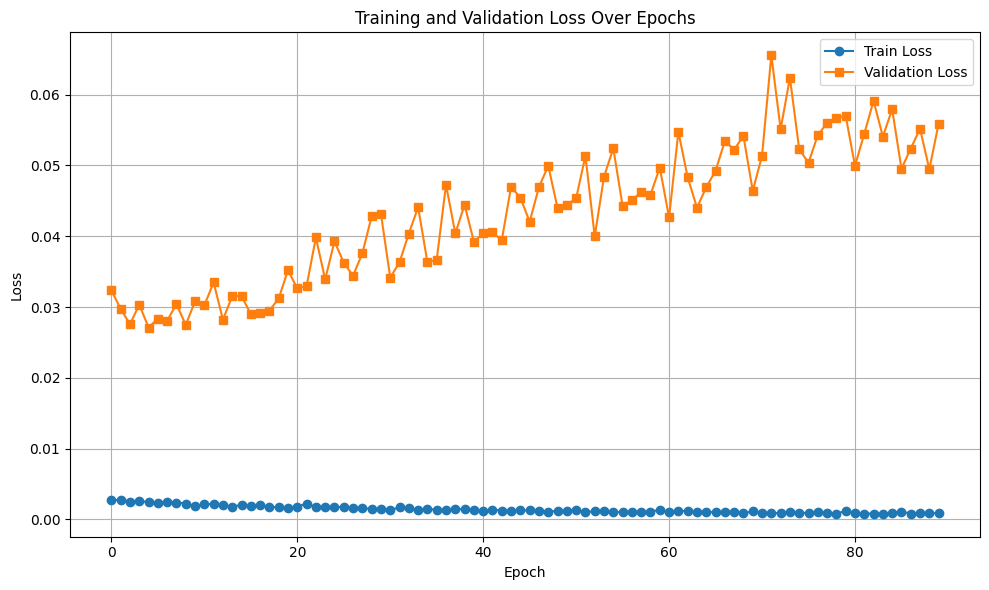

In [ ]:
# plot
import matplotlib.pyplot as plt

# Assuming you have already run:
# train_losses, val_losses = train_model(...)

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_losses(train_losses, val_losses)

In [ ]:
# save EfficientNetB0 model
save_path = '/content/drive/MyDrive/datasets/ODIR-5K/models/'
torch.save(model.state_dict(), os.path.join(save_path, 'EfficientNetB0_weights.pth'))
!cp best_model.pth /content/drive/MyDrive/datasets/ODIR-5K/models/best_model.pth

EfficientNetB4

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = siamese.DualInputEfficientNetB4(num_classes=8, weights='DEFAULT')

train_losses, val_losses = train_model(model, train_loader, val_loader, device)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
 81%|████████  | 60.0M/74.5M [00:01<00:00, 50.3MB/s]


KeyboardInterrupt: 

Resnet18 Imagenet

In [ ]:
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('resnet18', pretrained=True, num_classes=8)

model = siamese.DualInputResNet18(model, num_classes=8)

train_losses, val_losses = train_model(model, train_loader, val_loader, device)

Epoch [1/90], Batch [10/66] Train Loss: 0.052
Epoch [1/90], Batch [20/66] Train Loss: 0.038
Epoch [1/90], Batch [30/66] Train Loss: 0.034
Epoch [1/90], Batch [40/66] Train Loss: 0.034
Epoch [1/90], Batch [50/66] Train Loss: 0.033
Epoch [1/90], Batch [60/66] Train Loss: 0.032
Epoch [1/90] Validation Loss: 0.031
Best model saved (Val Loss: 0.031)
Epoch [2/90], Batch [10/66] Train Loss: 0.032
Epoch [2/90], Batch [20/66] Train Loss: 0.032
Epoch [2/90], Batch [30/66] Train Loss: 0.031
Epoch [2/90], Batch [40/66] Train Loss: 0.030
Epoch [2/90], Batch [50/66] Train Loss: 0.032
Epoch [2/90], Batch [60/66] Train Loss: 0.030
Epoch [2/90] Validation Loss: 0.029
Best model saved (Val Loss: 0.029)
Epoch [3/90], Batch [10/66] Train Loss: 0.030
Epoch [3/90], Batch [20/66] Train Loss: 0.030
Epoch [3/90], Batch [30/66] Train Loss: 0.029
Epoch [3/90], Batch [40/66] Train Loss: 0.030
Epoch [3/90], Batch [50/66] Train Loss: 0.030
Epoch [3/90], Batch [60/66] Train Loss: 0.031
Epoch [3/90] Validation Loss: 

In [ ]:
torch.save(model.state_dict(), 'final_effnetb0.pth')

In [ ]:
model.load_state_dict(torch.load('best_model.pth'))
_,_,_,_,_,_,_,thresholds = evaluate_model(model, val_loader, device, optimize_thresholds=True)


 Average Loss: 0.0263, Accuracy: 0.8702, Macro AUC: 0.8441, Macro F1: 0.5953, Macro Precision: 0.5879, Macro Recall: 0.6906, Macro PR_AUC: 0.5971

 Per-class Optimal Thresholds:
  [N] Threshold: 0.35
  [D] Threshold: 0.30
  [G] Threshold: 0.30
  [C] Threshold: 0.25
  [A] Threshold: 0.30
  [H] Threshold: 0.35
  [M] Threshold: 0.60
  [O] Threshold: 0.25

 Per-class Metrics:
  [N] Precision: 0.524 | Recall: 0.772 | F1: 0.624 | PR-AUC: 0.614
  [D] Precision: 0.466 | Recall: 0.855 | F1: 0.603 | PR-AUC: 0.668
  [G] Precision: 0.500 | Recall: 0.525 | F1: 0.512 | PR-AUC: 0.495
  [C] Precision: 0.707 | Recall: 0.879 | F1: 0.784 | PR-AUC: 0.814
  [A] Precision: 0.857 | Recall: 0.414 | F1: 0.558 | PR-AUC: 0.561
  [H] Precision: 0.417 | Recall: 0.208 | F1: 0.278 | PR-AUC: 0.200
  [M] Precision: 0.902 | Recall: 0.925 | F1: 0.914 | PR-AUC: 0.969
  [O] Precision: 0.331 | Recall: 0.947 | F1: 0.490 | PR-AUC: 0.456


In [ ]:
print(thresholds)

[np.float64(0.3), np.float64(0.35), np.float64(0.35), np.float64(0.25), np.float64(0.2), np.float64(0.25), np.float64(0.25), np.float64(0.3)]


In [ ]:
avg_loss, accuracy, macro_auc, macro_f1,macro_precision, macro_recall, macro_pr_auc, best_thresholds = evaluate_model(model, test_loader, device, best_thresholds=thresholds)



 Average Loss: 0.0275, Accuracy: 0.8712, Macro AUC: 0.8159, Macro F1: 0.4994, Macro Precision: 0.4814, Macro Recall: 0.5883, Macro PR_AUC: 0.5447

 Per-class Optimal Thresholds:
  [N] Threshold: 0.35
  [D] Threshold: 0.30
  [G] Threshold: 0.30
  [C] Threshold: 0.25
  [A] Threshold: 0.30
  [H] Threshold: 0.35
  [M] Threshold: 0.60
  [O] Threshold: 0.25

 Per-class Metrics:
  [N] Precision: 0.457 | Recall: 0.689 | F1: 0.549 | PR-AUC: 0.517
  [D] Precision: 0.472 | Recall: 0.824 | F1: 0.600 | PR-AUC: 0.717
  [G] Precision: 0.514 | Recall: 0.487 | F1: 0.500 | PR-AUC: 0.511
  [C] Precision: 0.627 | Recall: 0.744 | F1: 0.681 | PR-AUC: 0.803
  [A] Precision: 0.562 | Recall: 0.281 | F1: 0.375 | PR-AUC: 0.437
  [H] Precision: 0.000 | Recall: 0.000 | F1: 0.000 | PR-AUC: 0.081
  [M] Precision: 0.889 | Recall: 0.727 | F1: 0.800 | PR-AUC: 0.914
  [O] Precision: 0.330 | Recall: 0.953 | F1: 0.490 | PR-AUC: 0.378


#ViT experiment

Vit 16

In [ ]:
import models as siamese
print(dir(siamese))

['DualInputEfficientNetB0', 'DualInputEfficientNetB4', 'DualInputEfficientNetB6', 'DualInputEfficientNetB7', 'DualInputResNet18', 'DualInputViT_b_16', 'F', 'LayerNorm2d', 'SiameseConvnext_base', 'SiameseVGG11', 'SiameseVGG13', 'SiameseVGG16', 'SiameseVGG19', 'SiameseVit_b_32', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_dual_input_retinamnist_resnet18', 'models', 'nn', 'timm', 'torch']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = siamese.DualInputViT_b_16(num_classes=8, weights='DEFAULT')

train_losses, val_losses = train_model(model, train_loader, val_loader, device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:07<00:00, 46.7MB/s]


KeyboardInterrupt: 

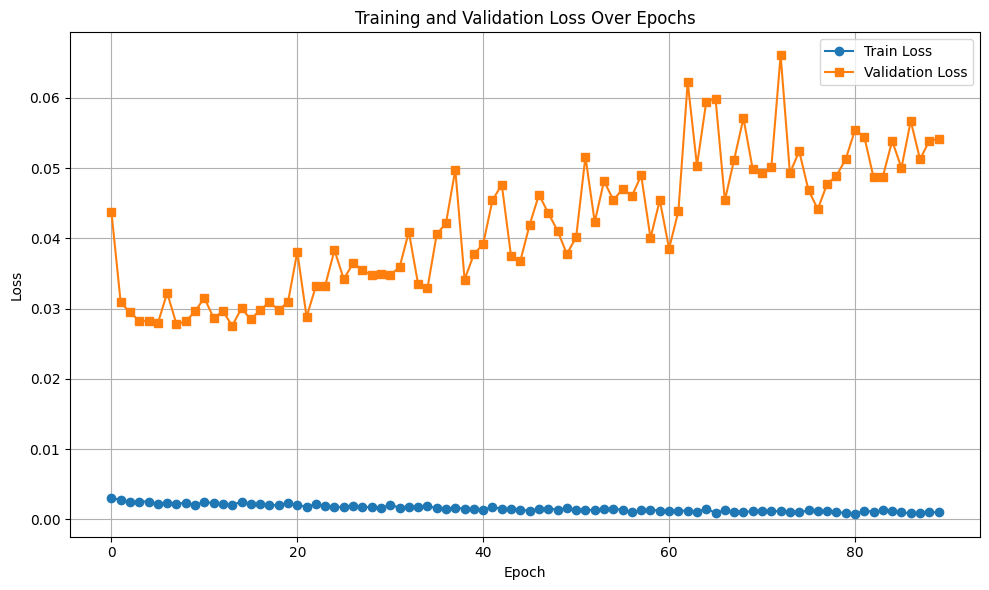

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already run:
# train_losses, val_losses = train_model(...)

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Validation Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs - EfficientNetB4')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_losses(train_losses, val_losses)

In [ ]:
save_path = '/content/drive/MyDrive/datasets/ODIR-5K/models/'
torch.save(model.state_dict(), os.path.join(save_path, 'Vit16_weights.pth'))
!cp best_model.pth /content/drive/MyDrive/datasets/ODIR-5K/models/best_vit_model.pth

In [ ]:

model_path = '/content/drive/MyDrive/datasets/ODIR-5K/models/best_model-4.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = siamese.DualInputViT_b_16(num_classes=8, weights='DEFAULT')
model.load_state_dict(torch.load(model_path))  # Load saved weights
model.to(device)


train_losses, val_losses = train_model(model, train_loader, val_loader, device, epoch_start=70)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 100MB/s] 


Epoch [71/90], Batch [10/66] Train Loss: 0.033
Epoch [71/90], Batch [20/66] Train Loss: 0.032
Epoch [71/90], Batch [30/66] Train Loss: 0.031
Epoch [71/90], Batch [40/66] Train Loss: 0.032
Epoch [71/90], Batch [50/66] Train Loss: 0.033
Epoch [71/90], Batch [60/66] Train Loss: 0.033
Epoch [71/90] Validation Loss: 0.032
Best model saved (Val Loss: 0.032)
Epoch [72/90], Batch [10/66] Train Loss: 0.032
Epoch [72/90], Batch [20/66] Train Loss: 0.032
Epoch [72/90], Batch [30/66] Train Loss: 0.033
Epoch [72/90], Batch [40/66] Train Loss: 0.034
Epoch [72/90], Batch [50/66] Train Loss: 0.032
Epoch [72/90], Batch [60/66] Train Loss: 0.032
Epoch [72/90] Validation Loss: 0.032
Best model saved (Val Loss: 0.032)
Epoch [73/90], Batch [10/66] Train Loss: 0.033
Epoch [73/90], Batch [20/66] Train Loss: 0.032
Epoch [73/90], Batch [30/66] Train Loss: 0.032
Epoch [73/90], Batch [40/66] Train Loss: 0.034
Epoch [73/90], Batch [50/66] Train Loss: 0.032
Epoch [73/90], Batch [60/66] Train Loss: 0.031
Epoch [73/

In [ ]:
save_path = '/content/drive/MyDrive/datasets/ODIR-5K/models/'
torch.save(model.state_dict(), os.path.join(save_path, 'Vit16_weights.pth'))
!cp best_model.pth /content/drive/MyDrive/datasets/ODIR-5K/models/best_vit_model.pth

In [ ]:
print(train_losses)
print(val_losses)

[0.002977826152787064, 0.002899207400553154, 0.003008123148571361, 0.0029822034817753415, 0.002772544171999801, 0.0028187201047937074, 0.002854493700645187, 0.0030041265611847243, 0.0027774407274343753, 0.0030145477785757093, 0.0028810291692163005, 0.002881379374726252, 0.0029176664115353064, 0.0028670533193331776, 0.0029350713629162674, 0.0029024258255958557, 0.0027875732066053333, 0.002850438073051698, 0.0027779328608603187, 0.0028999126939611]
[0.03235809394920414, 0.03200664942745458, 0.03196930406953801, 0.03217737524854866, 0.03189751035957174, 0.03212782410396771, 0.03187284055589275, 0.032148670362816614, 0.031947064721448856, 0.03207616440274499, 0.031894785944711075, 0.0319362830539996, 0.03174755870449272, 0.03173840545456518, 0.03170508590780876, 0.0318682810545645, 0.03175498016009277, 0.03230614778162404, 0.032329316293312746, 0.03153972141444683]


In [ ]:
import torch
model_path = '/content/drive/MyDrive/datasets/ODIR-5K/models/best_vit_model.pth'
thresholds = [0.30, 0.35, 0.35, 0.25, 0.20, 0.25, 0.25, 0.30]

torch.cuda.empty_cache()

model = siamese.DualInputViT_b_16(num_classes=8, weights='DEFAULT').to('cpu')
model.load_state_dict(torch.load(model_path, map_location='cpu'))

# Run evaluation
test_results = evaluate_model(
    model,
    test_loader,
    device='cpu',
    optimize_thresholds=False,
    best_thresholds=thresholds
)

KeyboardInterrupt: 

In [ ]:
print(test_results)

(0.02732363296672702, 0.875, np.float64(0.8344848539381049), 0.5225783666461572, 0.4986219986235021, 0.6149976548906073, np.float64(0.573562219553511), [0.3, 0.35, 0.35, 0.25, 0.2, 0.25, 0.25, 0.3])


In [ ]:
thresholds = [0.30, 0.35, 0.35, 0.25, 0.20, 0.25, 0.25, 0.30]
test_results = evaluate_model(model, val_loader, device='cpu', optimize_thresholds=False, best_thresholds=thresholds)


 Average Loss: 0.0298, Accuracy: 0.8786, Macro AUC: 0.8433, Macro F1: 0.5599, Macro Precision: 0.5119, Macro Recall: 0.6839, Macro PR_AUC: 0.5822

 Per-class Optimal Thresholds:
  [N] Threshold: 0.30
  [D] Threshold: 0.35
  [G] Threshold: 0.35
  [C] Threshold: 0.25
  [A] Threshold: 0.20
  [H] Threshold: 0.25
  [M] Threshold: 0.25
  [O] Threshold: 0.30

 Per-class Metrics:
  [N] Precision: 0.483 | Recall: 0.675 | F1: 0.563 | PR-AUC: 0.534
  [D] Precision: 0.652 | Recall: 0.590 | F1: 0.619 | PR-AUC: 0.729
  [G] Precision: 0.466 | Recall: 0.692 | F1: 0.557 | PR-AUC: 0.531
  [C] Precision: 0.825 | Recall: 0.767 | F1: 0.795 | PR-AUC: 0.840
  [A] Precision: 0.297 | Recall: 0.688 | F1: 0.415 | PR-AUC: 0.484
  [H] Precision: 0.096 | Recall: 0.529 | F1: 0.162 | PR-AUC: 0.207
  [M] Precision: 0.875 | Recall: 0.848 | F1: 0.862 | PR-AUC: 0.887
  [O] Precision: 0.403 | Recall: 0.681 | F1: 0.506 | PR-AUC: 0.446


Vit 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = siamese.SiameseVit_b_32(num_classes=8, weights='DEFAULT')

train_model(model, train_loader, val_loader, device)

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:05<00:00, 62.5MB/s]


Epoch [1/90], Batch [10/66] Train Loss: 0.063
Epoch [1/90], Batch [20/66] Train Loss: 0.040
Epoch [1/90], Batch [30/66] Train Loss: 0.036
Epoch [1/90], Batch [40/66] Train Loss: 0.035
Epoch [1/90], Batch [50/66] Train Loss: 0.035
Epoch [1/90], Batch [60/66] Train Loss: 0.036
Epoch [1/90] Validation Loss: 0.035
Best model saved (Val Loss: 0.035)
Epoch [2/90], Batch [10/66] Train Loss: 0.036
Epoch [2/90], Batch [20/66] Train Loss: 0.037
Epoch [2/90], Batch [30/66] Train Loss: 0.037
Epoch [2/90], Batch [40/66] Train Loss: 0.037
Epoch [2/90], Batch [50/66] Train Loss: 0.035
Epoch [2/90], Batch [60/66] Train Loss: 0.035
Epoch [2/90] Validation Loss: 0.034
Best model saved (Val Loss: 0.034)
Epoch [3/90], Batch [10/66] Train Loss: 0.036
Epoch [3/90], Batch [20/66] Train Loss: 0.037
Epoch [3/90], Batch [30/66] Train Loss: 0.037
Epoch [3/90], Batch [40/66] Train Loss: 0.041
Epoch [3/90], Batch [50/66] Train Loss: 0.039
Epoch [3/90], Batch [60/66] Train Loss: 0.037
Epoch [3/90] Validation Loss: 

([0.003383009553407178,
  0.003391886299306696,
  0.003325923712867679,
  0.003300581183848959,
  0.0031892246933597507,
  0.003515408459034833,
  0.0033282075415958057,
  0.003452919028473623,
  0.00317212442557017,
  0.003289824520999735,
  0.00332025805431785,
  0.003164635745413376,
  0.0032113472733533745,
  0.003099093016124133,
  0.003015173232239304,
  0.003070673312653195,
  0.003283463531371319,
  0.0033355698441014147,
  0.003258043166362878,
  0.003185191953724081,
  0.0030113122792858067,
  0.0030917106478503256,
  0.0031193155005122676,
  0.0031488476264657397,
  0.0031791554594581776,
  0.003166130151260983,
  0.002927781054467866,
  0.003154236033107295,
  0.003378269516608932,
  0.003185695940346429,
  0.003126409243453633,
  0.0031367679211226377,
  0.0032345702250798545,
  0.003106532900622397,
  0.003119312904097817,
  0.0031208845250534287,
  0.0029267586598342114,
  0.003084372729063034,
  0.0029376648422895055,
  0.003063510200290969,
  0.0030956035762122183,
  0

In [ ]:
train_losses = [0.0033147506641619134,
  0.003261287978878527,
  0.003230076396104061,
  0.003144344879370747,
  0.0031014874746853657,
  0.003172635552332257,
  0.0030316572749253473,
  0.003067486665465615,
  0.003101920567904458,
  0.0031584221587488146,
  0.0029731026540199914,
  0.003038590322389747,
  0.0029966098002412104,
  0.0031363570103139587,
  0.0028511142414627652,
  0.0029250011694702234,
  0.0029861614333860803,
  0.003031967772227345,
  0.0028807381732445774,
  0.00283047469389258,
  0.002822928187070471,
  0.0029435215630766115,
  0.0030135211224357286,
  0.0029657428632631445,
  0.0027718071571805262,
  0.002838889786014051,
  0.002913687773274653,
  0.002717295294683991,
  0.0028008168111696386,
  0.0026763213911291323,
  0.0029339470025716405,
  0.002717305172347661,
  0.0028234219855882907,
  0.0025670832643906274,
  0.0027454893640948067,
  0.002733055812617143,
  0.0028363586488095198,
  0.002790135359673789,
  0.0027695152852119822,
  0.00281461760063063,
  0.0026161610007737622,
  0.002542211899928974,
  0.0028159265039545116,
  0.0026434247918201217,
  0.0026514911741921396,
  0.0027008801980903654,
  0.002704515178320986,
  0.0027256151661276817,
  0.00264077963815494,
  0.002880632397577618,
  0.0026629036856871662,
  0.0028437059090444536,
  0.002503297348139864,
  0.0026644072636510386,
  0.002650937714585752,
  0.0025443873565756912,
  0.0026946459812196817,
  0.002498829878415122,
  0.0026422545144503765,
  0.0027750207845008736,
  0.0026430374745166664,
  0.002587043313365994,
  0.0025845167763305435,
  0.002613618885251609,
  0.0026240922849286685,
  0.002475340794207472,
  0.0025286393409425564,
  0.0026595872459989605,
  0.0025046018770698347,
  0.002698731157138492,
  0.0025609880685806274,
  0.0025073557697010765,
  0.0025308066979050636,
  0.0024613481522961097,
  0.002497134871329322,
  0.0022877359649900236,
  0.0025968307234121094,
  0.0025237631899389353,
  0.00242543655137221,
  0.002445144099042271,
  0.0025725533734216833,
  0.002462950563340476,
  0.0022736587420557485,
  0.0023389258845285935,
  0.0025403939864852214,
  0.0024693059932553406,
  0.002543177060557134,
  0.0023273238065567884,
  0.002070385003180215,
  0.002330114754537741]

val_losses = [0.03427887453951619,
  0.03399940486997366,
  0.03358868530697443,
  0.036054270172661,
  0.03436302440240979,
  0.033936547708104954,
  0.033128959042104805,
  0.03395152468742295,
  0.03286178367720409,
  0.033067125234414234,
  0.0335340374996039,
  0.03389317512681538,
  0.03336700183254751,
  0.03331440234218131,
  0.031780332369221884,
  0.033333281774751165,
  0.0315684844231741,
  0.03281468009068207,
  0.03221134570511905,
  0.03233320452272892,
  0.03299154675650326,
  0.03368397937579588,
  0.03266577363352884,
  0.036472252824089745,
  0.03177959734404629,
  0.032385507810183546,
  0.0314095045693896,
  0.032762885305353186,
  0.031031085982580076,
  0.0313376524400982,
  0.030955702743747017,
  0.03294390173290263,
  0.03099188149314035,
  0.03083960915153677,
  0.030937799718230963,
  0.03218811348249966,
  0.030500246592882006,
  0.0324086968109689,
  0.0316862006333064,
  0.030618870503861795,
  0.030763991939073258,
  0.030816622798077085,
  0.030191777062348345,
  0.03168756743385033,
  0.031061380508948456,
  0.030858437742360613,
  0.030061967713250357,
  0.030783960384062746,
  0.03009381847964092,
  0.030770662748678165,
  0.031119677153500645,
  0.03222548428245566,
  0.030932080550965937,
  0.03273738891055638,
  0.030980770433829588,
  0.030266855462369593,
  0.030616618735207754,
  0.030948521908033978,
  0.03146698490970514,
  0.0307790454138409,
  0.03175834659487009,
  0.031035501721569082,
  0.031485887794670736,
  0.030787174166603523,
  0.031005091753534296,
  0.0312011411244219,
  0.03116279294375669,
  0.03056908081370321,
  0.030555209271948446,
  0.03218969317491759,
  0.03088636217977513,
  0.03194901728155938,
  0.03374305731532248,
  0.031039457641203295,
  0.03130511837926778,
  0.031910358293151316,
  0.03204009114679965,
  0.03194079040126367,
  0.03151178707114675,
  0.03205167171968655,
  0.031445895110002973,
  0.032506676729429855,
  0.03178406798873435,
  0.03250519198958169,
  0.03459688297218897,
  0.03165905368091031,
  0.03223239748992703,
  0.031776349525898695,
  0.0333183332007717,
  0.03176776628771966]

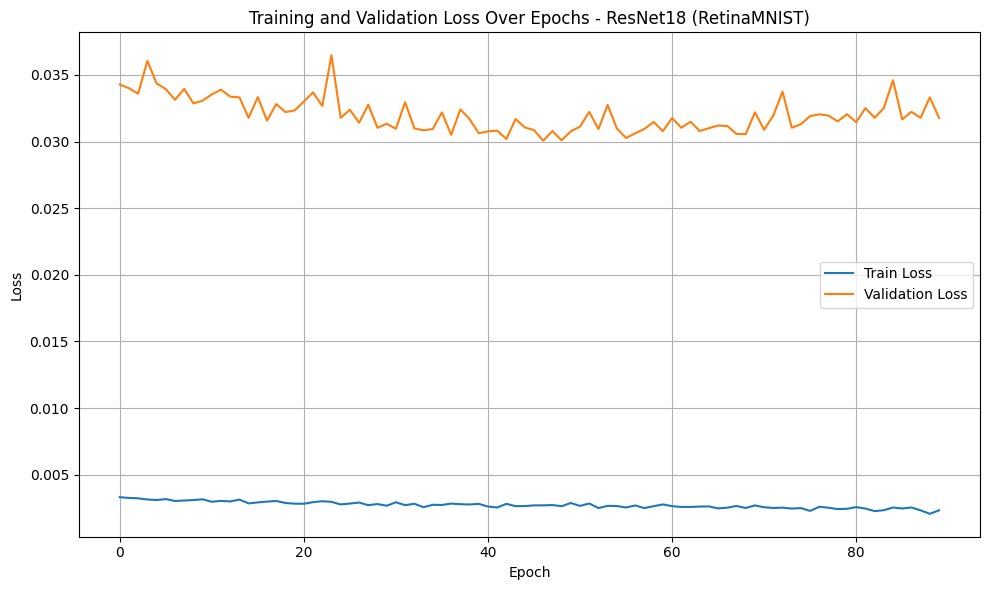

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already run:
# train_losses, val_losses = train_model(...)

def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs - ResNet18 (RetinaMNIST)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the function
plot_losses(train_losses, val_losses)


In [ ]:
save_path = '/content/drive/MyDrive/datasets/ODIR-5K/models/'
torch.save(model.state_dict(), os.path.join(save_path, 'Vit32_weights.pth'))
!cp best_model.pth /content/drive/MyDrive/datasets/ODIR-5K/models/best_model.pth


NameError: name 'model' is not defined

In [ ]:
import torch

model_path = '/content/drive/MyDrive/datasets/ODIR-5K/models/best_model.pth'

torch.cuda.empty_cache()

model = siamese.SiameseVit_b_32(num_classes=8, weights='DEFAULT').to('cpu')

model.load_state_dict(torch.load(model_path, map_location='cpu'))


evaluate_model(model, val_loader, device='cpu', optimize_thresholds=True, best_thresholds=None)


Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:08<00:00, 41.2MB/s]


#MedMNIST experiments

In [ ]:
!wget -q https://zenodo.org/record/7782114/files/weights_retinamnist.zip
!unzip -q weights_retinamnist.zip "resnet18_224_1.pth"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = siamese.create_dual_input_retinamnist_resnet18(num_classes=8, weightsFile='resnet18_224_1.pth')

train_model(model, train_loader, val_loader, device)

Epoch [1/90], Batch [10/66] Train Loss: 0.059
Epoch [1/90], Batch [20/66] Train Loss: 0.039
Epoch [1/90], Batch [30/66] Train Loss: 0.038
Epoch [1/90], Batch [40/66] Train Loss: 0.038
Epoch [1/90], Batch [50/66] Train Loss: 0.037
Epoch [1/90], Batch [60/66] Train Loss: 0.036
Epoch [1/90] Validation Loss: 0.034
Best model saved (Val Loss: 0.034)
Epoch [2/90], Batch [10/66] Train Loss: 0.035
Epoch [2/90], Batch [20/66] Train Loss: 0.036
Epoch [2/90], Batch [30/66] Train Loss: 0.036
Epoch [2/90], Batch [40/66] Train Loss: 0.036
Epoch [2/90], Batch [50/66] Train Loss: 0.036
Epoch [2/90], Batch [60/66] Train Loss: 0.034
Epoch [2/90] Validation Loss: 0.034
Best model saved (Val Loss: 0.034)
Epoch [3/90], Batch [10/66] Train Loss: 0.034
Epoch [3/90], Batch [20/66] Train Loss: 0.035
Epoch [3/90], Batch [30/66] Train Loss: 0.036
Epoch [3/90], Batch [40/66] Train Loss: 0.037
Epoch [3/90], Batch [50/66] Train Loss: 0.034
Epoch [3/90], Batch [60/66] Train Loss: 0.035
Epoch [3/90] Validation Loss: 

([0.0033147506641619134,
  0.003261287978878527,
  0.003230076396104061,
  0.003144344879370747,
  0.0031014874746853657,
  0.003172635552332257,
  0.0030316572749253473,
  0.003067486665465615,
  0.003101920567904458,
  0.0031584221587488146,
  0.0029731026540199914,
  0.003038590322389747,
  0.0029966098002412104,
  0.0031363570103139587,
  0.0028511142414627652,
  0.0029250011694702234,
  0.0029861614333860803,
  0.003031967772227345,
  0.0028807381732445774,
  0.00283047469389258,
  0.002822928187070471,
  0.0029435215630766115,
  0.0030135211224357286,
  0.0029657428632631445,
  0.0027718071571805262,
  0.002838889786014051,
  0.002913687773274653,
  0.002717295294683991,
  0.0028008168111696386,
  0.0026763213911291323,
  0.0029339470025716405,
  0.002717305172347661,
  0.0028234219855882907,
  0.0025670832643906274,
  0.0027454893640948067,
  0.002733055812617143,
  0.0028363586488095198,
  0.002790135359673789,
  0.0027695152852119822,
  0.00281461760063063,
  0.002616161000773

In [ ]:
!pip install grad-cam


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 861.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.0 MB/s 

In [47]:
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from torchvision.models import efficientnet_b3
import torchvision.transforms as T
from pytorch_grad_cam import GradCAM

from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

save_path = '/content/drive/MyDrive/datasets/ODIR-5K/models/'

model = siamese.DualInputEfficientNetB0(num_classes=8)
model.load_state_dict(torch.load(os.path.join(save_path, 'best_effnetb0.pth'), map_location=torch.device('cpu')))
model.eval().to(device)




DualInputEfficientNetB0(
  (efficientnet): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
     

In [56]:
model = siamese.SiameseVit_b_32(num_classes=8)
model.load_state_dict(torch.load(os.path.join(save_path, 'best_vit32.pth'), map_location=torch.device('cpu')))
model.eval().to(device)


SiameseVit_b_32(
  (vit): VisionTransformer(
    (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (encoder): Encoder(
      (dropout): Dropout(p=0.0, inplace=False)
      (layers): Sequential(
        (encoder_layer_0): EncoderBlock(
          (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (self_attention): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (dropout): Dropout(p=0.0, inplace=False)
          (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): MLPBlock(
            (0): Linear(in_features=768, out_features=3072, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=3072, out_features=768, bias=True)
            (4): Dropout(p=0.0, inplace=False)
          )
        )
        (encoder_layer_1): EncoderBlock(
          (ln_1): L

In [ ]:
sample_idx = train_df[train_df['A'] == 1].index[3]
left_path = os.path.join(preprocessed_dir, train_df.loc[sample_idx, 'Left-Fundus'])
right_path = os.path.join(preprocessed_dir, train_df.loc[sample_idx, 'Right-Fundus'])
print(print(left_path))

/content/drive/MyDrive/datasets/ODIR-5K/images/preprocessed/1862_left.jpg
None


In [48]:
class LeftEyeWrapper(torch.nn.Module):
    def __init__(self, model, right_img):
        super().__init__()
        self.model = model
        self.right_img = right_img  # Fixed input

    def forward(self, left_img):
        return self.model(left_img, self.right_img)


class RightEyeWrapper(torch.nn.Module):
    def __init__(self, model, left_img):
        super().__init__()
        self.model = model
        self.left_img = left_img  # Fixed input

    def forward(self, right_img):
        return self.model(self.left_img, right_img)

def preprocess_image(path):
    img = Image.open(path).convert('RGB').resize((224, 224))
    img_np = np.array(img).astype(np.float32) / 255.0
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    tensor = transform(img).unsqueeze(0).to(device)
    return tensor, img_np


In [ ]:
sample_idx = 48  # from your log
row = train_df.loc[sample_idx]

left_path = os.path.join(preprocessed_dir, row['Left-Fundus'])
right_path = os.path.join(preprocessed_dir, row['Right-Fundus'])

print("Left Eye Image Path:", left_path)
print("Right Eye Image Path:", right_path)


Left Eye Image Path: /content/drive/MyDrive/datasets/ODIR-5K/images/preprocessed/48_left.jpg
Right Eye Image Path: /content/drive/MyDrive/datasets/ODIR-5K/images/preprocessed/48_right.jpg


In [23]:
import matplotlib.pyplot as plt

def run_multilabel_gradcam_pp(model, left_path, right_path, row, class_indices):
    left_tensor, left_np = preprocess_image(left_path)
    right_tensor, right_np = preprocess_image(right_path)
    target_layer = model.efficientnet.features[-1][0]

    # Your custom per-class thresholds (aligned by class_indices)
    thresholds = [0.30, 0.35, 0.35, 0.25, 0.20, 0.25, 0.25, 0.30]

    # Get all true labels from the row
    true_classes = [name for name in class_indices if row[name] == 1]
    print(true_classes)

    # Predict to show additional context
    with torch.no_grad():
        preds = model(left_tensor.to(device), right_tensor.to(device))
        preds = torch.sigmoid(preds).squeeze().cpu().numpy()
        print(f"Raw score for the class in point: {preds[class_indices['C']]:.4f} (Threshold: 0.25)")

        # Apply thresholds
        predicted_classes = [
            name for name, idx in class_indices.items()
            if preds[idx] > thresholds[idx]
        ]

    print(f"True Labels:      {true_classes}")
    print(f"Predicted Labels: {predicted_classes}")

    # Loop through all true labels and generate Grad-CAM++ maps
    for cls_name in true_classes:
        cls_idx = class_indices[cls_name]

        # Left eye
        cam_left = GradCAMPlusPlus(model=LeftEyeWrapper(model, right_tensor).to(device),
                                   target_layers=[target_layer])
        grayscale_left = cam_left(input_tensor=left_tensor, targets=[ClassifierOutputTarget(cls_idx)])[0]
        overlay_left = show_cam_on_image(left_np, grayscale_left, use_rgb=True)

        # Right eye
        cam_right = GradCAMPlusPlus(model=RightEyeWrapper(model, left_tensor).to(device),
                                    target_layers=[target_layer])
        grayscale_right = cam_right(input_tensor=right_tensor, targets=[ClassifierOutputTarget(cls_idx)])[0]
        overlay_right = show_cam_on_image(right_np, grayscale_right, use_rgb=True)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(overlay_left)
        axes[0].set_title(f"Left Eye - {cls_name}")
        axes[0].axis('off')
        axes[1].imshow(overlay_right)
        axes[1].set_title(f"Right Eye - {cls_name}")
        axes[1].axis('off')
        plt.suptitle(f"Grad-CAM++ for {cls_name} | True Labels: {true_classes} | Pred: {predicted_classes}")
        plt.tight_layout()
        plt.show()


In [24]:
# Class index mapping for ODIR
class_indices = {'N': 0, 'D': 1, 'G': 2, 'C': 3, 'A': 4, 'H': 5, 'M': 6, 'O': 7}


# Filter rows where A == 1 and all other class columns are 0
amd_only_df = val_df[
    (val_df['N'] == 1) &
    (val_df[[col for col in class_indices.keys() if col != 'H']].sum(axis=1) == 0)
]
first_sample  = amd_only_df.iloc[0]




left_path = os.path.join(preprocessed_dir, first_sample['Left-Fundus'])
right_path = os.path.join(preprocessed_dir, first_sample['Right-Fundus'])

run_multilabel_gradcam_pp(model, right_path, right_path, first_sample, class_indices)


IndexError: single positional indexer is out-of-bounds

['C']
Raw score for 'C': 0.3652 (Threshold: 0.25)
True Labels:      ['C']
Predicted Labels: ['N', 'C']


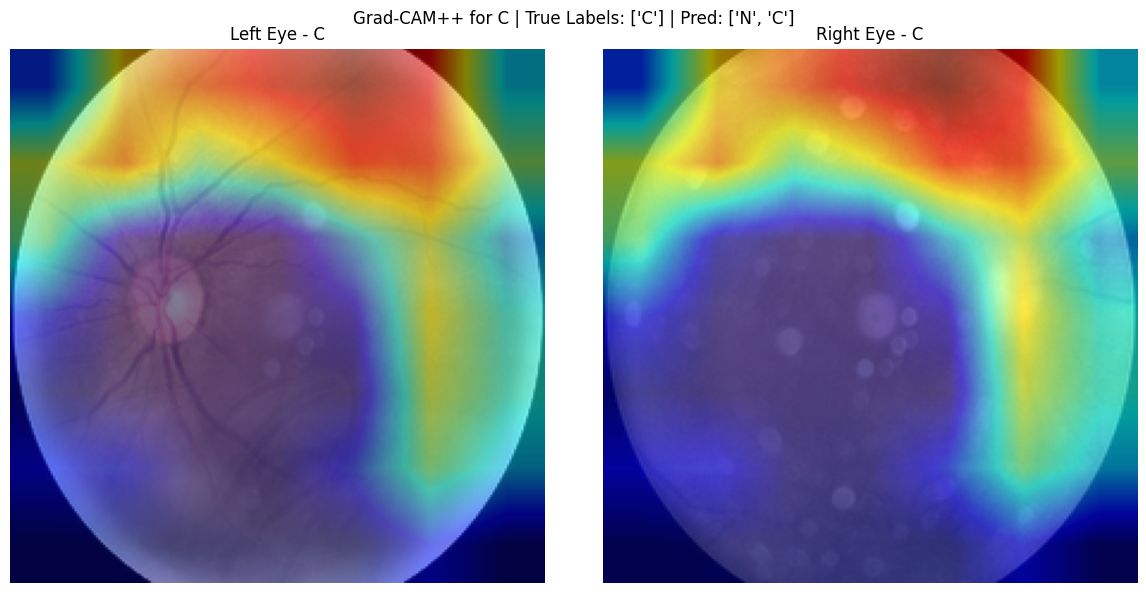

In [ ]:
right_path = os.path.join(preprocessed_dir, first_sample['Right-Fundus'])
run_multilabel_gradcam_pp(model, left_path, right_path, first_sample, class_indices)


In [ ]:
def get_target_layer(model):
    if hasattr(model, 'base_model'):
        base = model.base_model
        if hasattr(base, 'layer4'):
            return base.layer4[-1]  # torchvision ResNet
        elif hasattr(base, 'blocks'):
            return base.blocks[-1]  # timm ResNet
    elif hasattr(model, 'efficientnet'):
        return model.efficientnet.features[-1][0]  # EfficientNet-B0
    elif hasattr(model, 'vit'):
        return model.vit.encoder.layers[-1].ln_1  # Better than encoder.ln for ViT-B/32
    raise ValueError("Cannot determine target layer")


def reshape_transform_vit_b32(tensor):
  B, N, C = tensor.shape  # [B, 50, 768]
  H = W = 7
  return tensor[:, 1:, :].reshape(B, H, W, C).permute(0, 3, 1, 2)  # → [B, C, H, W]


def run_gradcam_for_class(model, left_path, right_path, class_label, row, class_indices):
    left_tensor, left_np = preprocess_image(left_path)
    right_tensor, right_np = preprocess_image(right_path)
    target_layer = get_target_layer(model)
    use_reshape = model.__class__.__name__ == 'SiameseVit_b_32'
    reshape = reshape_transform_vit_b32 if use_reshape else None
    class_idx = class_indices[class_label]

    # Predict
    with torch.no_grad():
        logits = model(left_tensor.to(device), right_tensor.to(device))
        probs = torch.sigmoid(logits).squeeze().cpu().numpy()

    thresholds = [0.30, 0.35, 0.35, 0.25, 0.20, 0.25, 0.25, 0.30]
    predicted_labels = [
        name for name, idx in class_indices.items()
        if probs[idx] > thresholds[idx]
    ]
    true_labels = [name for name in class_indices if row[name] == 1]

     # GradCAM++ Left
    cam_left = GradCAMPlusPlus(
        model=LeftEyeWrapper(model, right_tensor).to(device),
        target_layers=[target_layer],
        reshape_transform=reshape
    )
    grayscale_left = cam_left(input_tensor=left_tensor, targets=[ClassifierOutputTarget(class_idx)])[0]
    overlay_left = show_cam_on_image(left_np, grayscale_left, use_rgb=True)

    # GradCAM++ Right
    cam_right = GradCAMPlusPlus(
        model=RightEyeWrapper(model, left_tensor).to(device),
        target_layers=[target_layer],
        reshape_transform=reshape
    )
    grayscale_right = cam_right(input_tensor=right_tensor, targets=[ClassifierOutputTarget(class_idx)])[0]
    overlay_right = show_cam_on_image(right_np, grayscale_right, use_rgb=True)

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(overlay_left)
    axes[0].set_title(f"Left Eye - {class_label}")
    axes[0].axis('off')
    axes[1].imshow(overlay_right)
    axes[1].set_title(f"Right Eye - {class_label}")
    axes[1].axis('off')

    plt.suptitle(
        f"Grad-CAM++ for '{class_label}'\n"
        f"True Labels: {true_labels}\n"
        f"Predicted Labels: {predicted_labels}"
    )
    plt.tight_layout()
    plt.show()



 Processing class: N


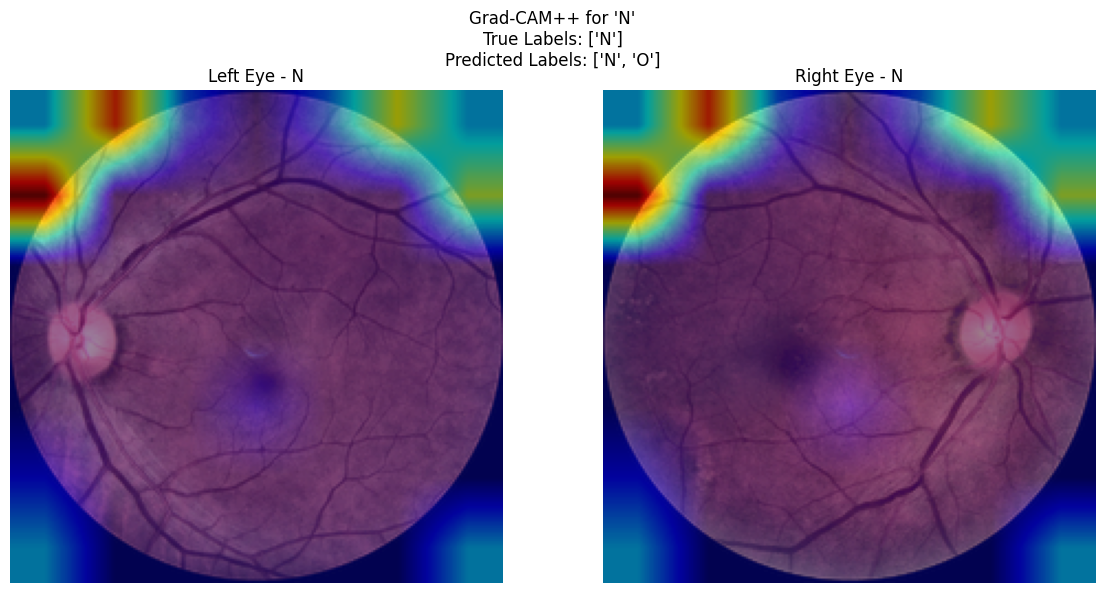


 Processing class: D


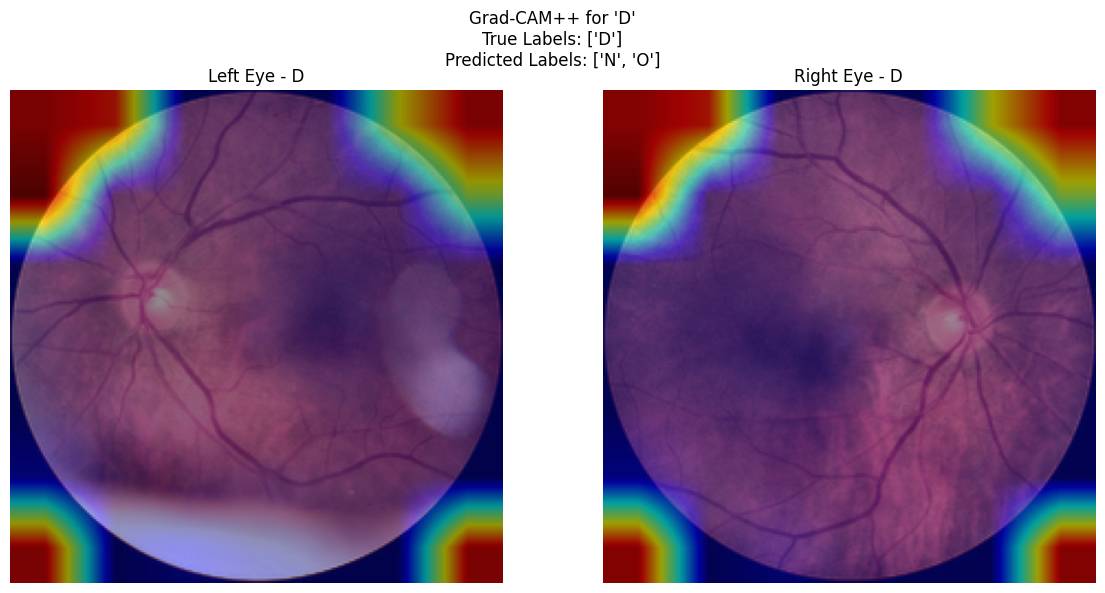


 Processing class: G


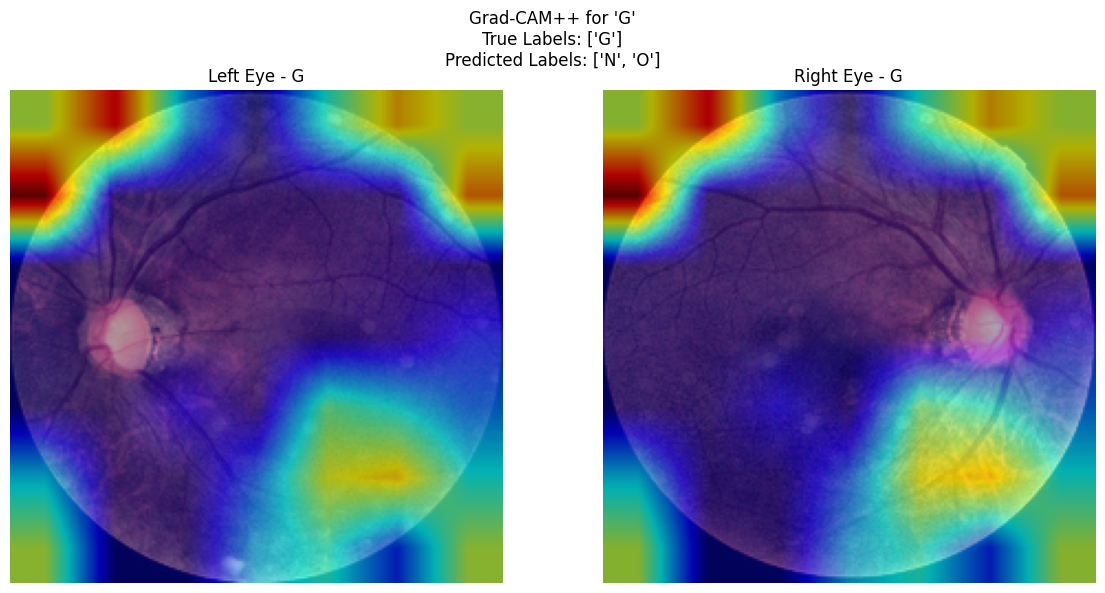


 Processing class: C


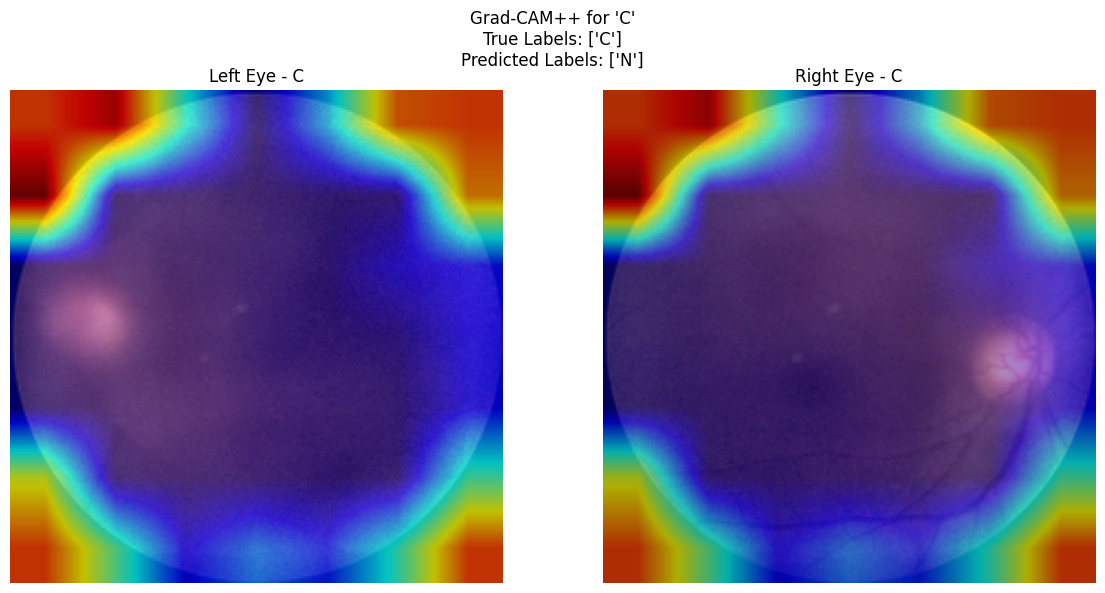


 Processing class: A


In [ ]:
class_indices = {'N': 0, 'D': 1, 'G': 2, 'C': 3, 'A': 4, 'H': 5, 'M': 6, 'O': 7}

for cls in class_indices.keys():
    print(f"\n Processing class: {cls}")
    cls_df = val_df[
        (val_df[cls] == 1) &
        (val_df[[c for c in class_indices if c != cls]].sum(axis=1) == 0)
    ]
    if cls_df.empty:
        print(f"No exclusive sample found for class: {cls}")
        continue

    row = cls_df.iloc[0]
    left_path = os.path.join(preprocessed_dir, row['Left-Fundus'])
    right_path = os.path.join(preprocessed_dir, row['Right-Fundus'])
    run_gradcam_for_class(model, left_path, right_path, cls, row, class_indices)


In [42]:
import torchvision.models as models

# Step 1: Load base ResNet18
base_model = models.resnet18(pretrained=True)
base_model.num_features = base_model.fc.in_features  # Add this if needed by your model logic


model = siamese.DualInputResNet18(base_model=base_model, num_classes=8)

# Step 3: Load weights
model.load_state_dict(torch.load(os.path.join(save_path, 'resnet18imagenet.pth'), map_location=torch.device('cpu')))

# Step 4: Set to evaluation mode and move to device
model.eval().to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DualInputResNet18(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr